In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [3]:
# Step 2: Load Dataset
df = pd.read_csv('udemy_output_All_Finance__Accounting_p1_p626.csv')
print("Initial Data:")
print(df.head())

Initial Data:
        id                                              title  \
0   762616  The Complete SQL Bootcamp 2020: Go from Zero t...   
1   937678  Tableau 2020 A-Z: Hands-On Tableau Training fo...   
2  1361790             PMP Exam Prep Seminar -  PMBOK Guide 6   
3   648826         The Complete Financial Analyst Course 2020   
4   637930  An Entire MBA in 1 Course:Award Winning Busine...   

                                                 url  is_paid  \
0                 /course/the-complete-sql-bootcamp/     True   
1                                 /course/tableau10/     True   
2                        /course/pmp-pmbok6-35-pdus/     True   
3     /course/the-complete-financial-analyst-course/     True   
4  /course/an-entire-mba-in-1-courseaward-winning...     True   

   num_subscribers  avg_rating  avg_rating_recent   rating  num_reviews  \
0           295509     4.66019            4.67874  4.67874        78006   
1           209070     4.58956            4.60015  4.6

In [4]:
# Step 3: Basic Cleaning
# Remove special characters in price columns and convert to numeric
df['discount_price__amount'] = df['discount_price__amount'].replace('[^0-9.]', '', regex=True).astype(float)
df['price_detail__amount'] = df['price_detail__amount'].replace('[^0-9.]', '', regex=True).astype(float)

# Convert boolean-like text to proper boolean
df['is_paid'] = df['is_paid'].astype(str).str.lower().map({'true': True, 'false': False})

In [5]:
# Step 4: Handle Missing Values
imputer = SimpleImputer(strategy='median')
df[['discount_price__amount', 'price_detail__amount']] = imputer.fit_transform(
    df[['discount_price__amount', 'price_detail__amount']]
)

# Step 5: Currency Conversion (INR → USD)
df['discount_price__amount'] = df['discount_price__amount'] * (1 / 82)
df['price_detail__amount'] = df['price_detail__amount'] * (1 / 82)

# Step 6: Calculate Discount Percentage
df['Discount_Percentage'] = ((df['price_detail__amount'] - df['discount_price__amount'])
                              / df['price_detail__amount']) * 100

In [6]:
# Step 7: Clean the Title
df['title'] = df['title'].str.lower().str.strip().replace(r'\s+', ' ', regex=True)
df['title'] = df['title'].str.replace(r'[^\w\s]', '', regex=True)

In [7]:
# Step 8: Categorize Courses by Keywords
def categorize_title(title):
    t = title.lower()
    if 'sql' in t or 'mysql' in t: return 'Database'
    elif 'tableau' in t or 'power bi' in t: return 'Data Visualization'
    elif 'excel' in t: return 'Spreadsheet'
    elif any(k in t for k in ['agile', 'scrum', 'pmp']): return 'Project Management'
    elif any(k in t for k in ['finance', 'accounting', 'financial']): return 'Finance'
    elif 'mba' in t or 'business' in t: return 'Business'
    elif 'marketing' in t or 'sales' in t: return 'Sales/Marketing'
    elif any(k in t for k in ['data science', 'analytics', 'machine learning']): return 'Data Science'
    elif 'management' in t: return 'Management'
    elif 'leadership' in t: return 'Leadership'
    elif 'communication' in t: return 'Communication'
    else: return 'Other'

df['category'] = df['title'].apply(categorize_title)

# Step 9: Exploratory Data Analysis
print("\nCategory Distribution:\n", df['category'].value_counts())


Category Distribution:
 category
Other                 8973
Business              1436
Finance               1125
Management             641
Sales/Marketing        505
Spreadsheet            257
Project Management     252
Data Visualization     129
Data Science           100
Leadership              74
Communication           73
Database                43
Name: count, dtype: int64


In [8]:
# Top 10 courses by subscribers
top_subs = df.nlargest(10, 'num_subscribers')
px.bar(top_subs, x='num_subscribers', y='title', orientation='h',
       title='Top 10 Courses by Number of Subscribers').show()

In [9]:
# Top 10 by rating
top_ratings = df.nlargest(10, 'avg_rating')
px.bar(top_ratings, x='avg_rating', y='title', orientation='h',
       title='Top 10 Courses by Average Rating').show()

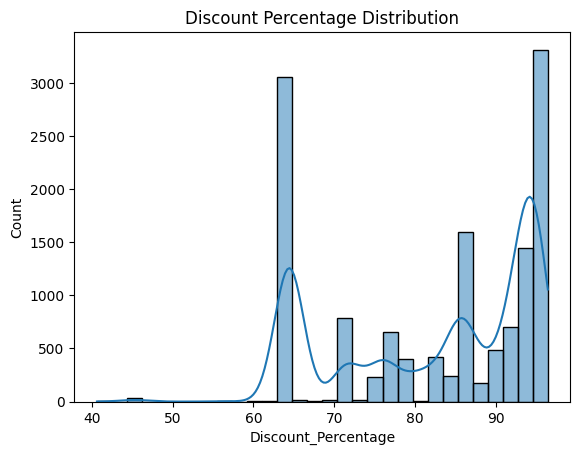

In [10]:
# Discount distribution
sns.histplot(df['Discount_Percentage'], bins=30, kde=True)
plt.title("Discount Percentage Distribution")
plt.show()

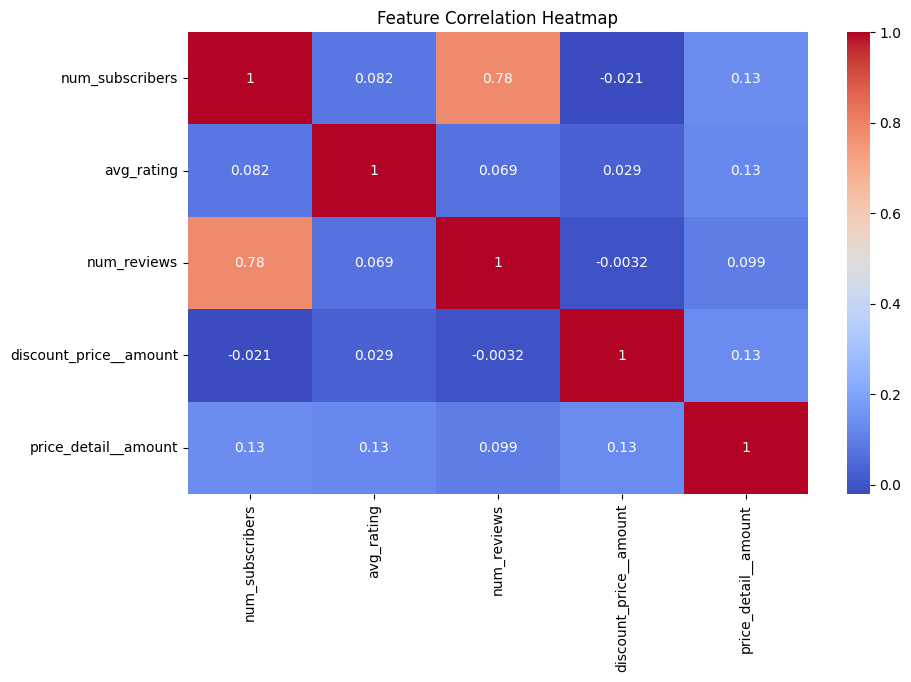

In [11]:
# Step 10: Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[['num_subscribers','avg_rating','num_reviews',
                'discount_price__amount','price_detail__amount']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Step 11: Machine Learning – Predict Subscribers
X = df[['avg_rating', 'num_reviews', 'num_published_lectures',
        'discount_price__amount', 'price_detail__amount']]
y = df['num_subscribers']

In [12]:
# Remove NaN rows
X = X.dropna()
y = y[X.index]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Model Performance:
Mean Squared Error: 37621552.55
R² Score: 0.69


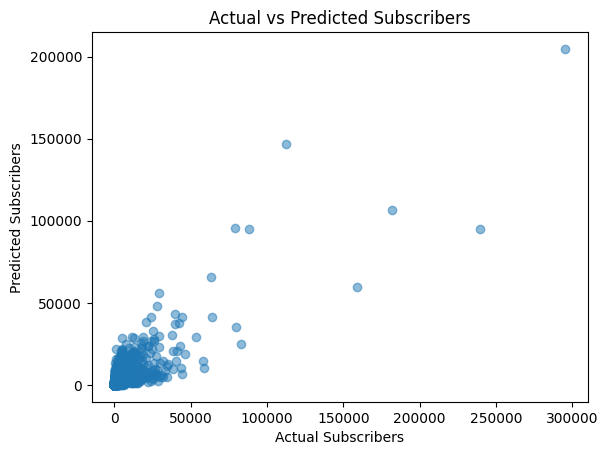


✅ Analysis Completed and Cleaned Dataset Saved!


In [13]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel Performance:\nMean Squared Error: {mse:.2f}\nR² Score: {r2:.2f}")

# Visualization of prediction performance
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Subscribers")
plt.ylabel("Predicted Subscribers")
plt.title("Actual vs Predicted Subscribers")
plt.show()

# Step 12: Save Cleaned Data
df.to_csv("Cleaned_Finance_Udemy.csv", index=False)
print("\n✅ Analysis Completed and Cleaned Dataset Saved!")